![](https://www.medicalnewstoday.com/content/images/articles/324/324956/close-up-of-a-plate-of-food.jpg)

# <div align="center"> Personalized All-You-Can-Eat recommendations! </div>

## <div align="center"> Encouraging your customers to eat. </div>

#### <div align="right"> Made by Ihor Markevych </div>

# Table of Content

1. [**Objective of the Project**](#obj)
1. [**Data Exploration**](#expl)
    1. [Rows quantity in dataset](#de1)
    1. [Head of data](#de2)
    1. [Missing values percentage](#de3)
    1. [Columns quantity and their types](#de4)
1. [**Data Cleaning and Subsetting**](#clean)
1. [**Dendrogram**](#dendro)
1. [**t-SNE**](#tsne)
1. [**Step-by-step K-Means**](#kmeans)
    1. [Recursive K-Means](#rec)
    1. [Iterative K-Mean](#iter)
    1. [K-Means Class](#class)
    1. [Basic Comparison](#comparison)
1. [**sklearn-cluster**](#sklearn)
1. [**Prediction**](#prediction)
1. [**2D prediction mesh**](#mesh)
1. [**Recommendations**](#recommendations)

<a id='obj'></a>
# Objective of the Project

Main goal of this project is to create clustering algorytm based on 3-5 features of college student. Dataset for this research can be found [here](https://www.kaggle.com/borapajo/food-choices/version/5).  
  
Data will be analyzed to find good variables for clustering, subsetted and cleaned.  
  
After this, number of clusters will be defined by doing additional investigations.  
  
Then, three custom K-Means will be created (iterative, recursive and Class-based). Data will be clustered based on those algorythms and on `sklearn.cluster.KMeans`.  
  
Clustered data will be investigated to get initial understanding of what does cluster represent.  
Based on this, basic dummy text for coupons will be created and function for printing coupon based on cluster will be implemented and tested on 10 random datapoints.  
  
Results will be visualized by 2d prediction mesh with usage of t-SNE to reduce dimensions of training data.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [2]:
d = pd.read_csv('food_coded.csv')

<a id='expl'></a>
# Data Exploration

<a id='de1'></a>
### Aspect 1: Rows quantity in dataset

Let's see, how big is our sample size. The bigger it is, the more externally valid results we can get.

In [3]:
print(f'There are {len(d)} rows in a dataset.')

There are 125 rows in a dataset.


Dataset is not very big, but we can assume that results can be generalixed, since sample is taken from college students and our population is also students of same college. 

<a id='de2'></a>
### Aspect 2: Head of data

Basic dataset and variables understanding can be given by checking first few rows of dataset.

In [4]:
d.head()

,GPA,Gender,breakfast,calories_chicken,calories_day,calories_scone,coffee,comfort_food,comfort_food_reasons,comfort_food_reasons_coded,...,soup,sports,thai_food,tortilla_calories,turkey_calories,type_sports,veggies_day,vitamins,waffle_calories,weight
0,2.4,2,1,430,NaN,315.0,1,none,we dont have comfort,9.0,...,1.0,1.0,1,1165.0,345,car racing,5,1,1315,187
1,3.654,1,1,610,3.0,420.0,2,"chocolate, chips, ice cream","Stress, bored, anger",1.0,...,1.0,1.0,2,725.0,690,Basketball,4,2,900,155
2,3.3,1,1,720,4.0,420.0,2,"frozen yogurt, pizza, fast food","stress, sadness",1.0,...,1.0,2.0,5,1165.0,500,none,5,1,900,I'm not answering this.
3,3.2,1,1,430,3.0,420.0,2,"Pizza, Mac and cheese, ice cream",Boredom,2.0,...,1.0,2.0,5,725.0,690,NaN,3,1,1315,"Not sure, 240"
4,3.5,1,1,720,2.0,420.0,2,"Ice cream, chocolate, chips","Stress, boredom, cravings",1.0,...,1.0,1.0,4,940.0,500,Softball,4,2,760,190


<a id='de3'></a>
### Aspect 3: Missing values percentage

Important criterea for selecting variables for clustering is missing values percentage. Let's find it.

In [5]:
(d.isnull().sum() * 100 / len(d)).sort_values(ascending=False).head(10)

type_sports                   16.8
calories_day                  15.2
comfort_food_reasons_coded    15.2
cuisine                       13.6
exercise                      10.4
employment                     7.2
cook                           2.4
eating_changes                 2.4
father_profession              2.4
meals_dinner_friend            2.4
dtype: float64

As we can see, some columns contain more than 10% of missing values. Other columns contain less than 2.5%.

<a id='de4'></a>
### Aspect 4: Columns quantity and their types

As part of our data exploration, let's discover how many columns do we have and what types of data they contain.

In [129]:
print(f'There are {len(d.columns)} columns.')

There are 61 columns.


Our dataset has next types of data by columns:

In [131]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 61 columns):
GPA                             123 non-null object
Gender                          125 non-null int64
breakfast                       125 non-null int64
calories_chicken                125 non-null int64
calories_day                    106 non-null float64
calories_scone                  124 non-null float64
coffee                          125 non-null int64
comfort_food                    124 non-null object
comfort_food_reasons            124 non-null object
comfort_food_reasons_coded      106 non-null float64
cook                            122 non-null float64
comfort_food_reasons_coded.1    125 non-null int64
cuisine                         108 non-null float64
diet_current                    124 non-null object
diet_current_coded              125 non-null int64
drink                           123 non-null float64
eating_changes                  122 non-null object
eating_chan

As it can be seen, we have 61 column, only some of them are numeric and so, only they fit our research. Also, we would like to use data without big percentage of missing values.

<a id='clean'></a>
# Data Cleaning and Subsetting

Let's use `GPA`, `calories_chicken`, `calories_scone`, `tortilla_calories`, `turkey_calories` for our clustering. Also, we need to perfrom data cleaning after subsetting. We will also scale data to $[0; 1]$ for better clustering results.

In [6]:
features = d[['GPA', 'calories_chicken', 'calories_scone', 'tortilla_calories', 'turkey_calories']]
features = features[pd.to_numeric(features['GPA'], errors='coerce').notnull()].dropna()
scaler = MinMaxScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

<a id='dendro'></a>
# Dendrogram

To decide on number of clusters, let's create a dendrogram. It can help us to visually guess number of clusters for our research.

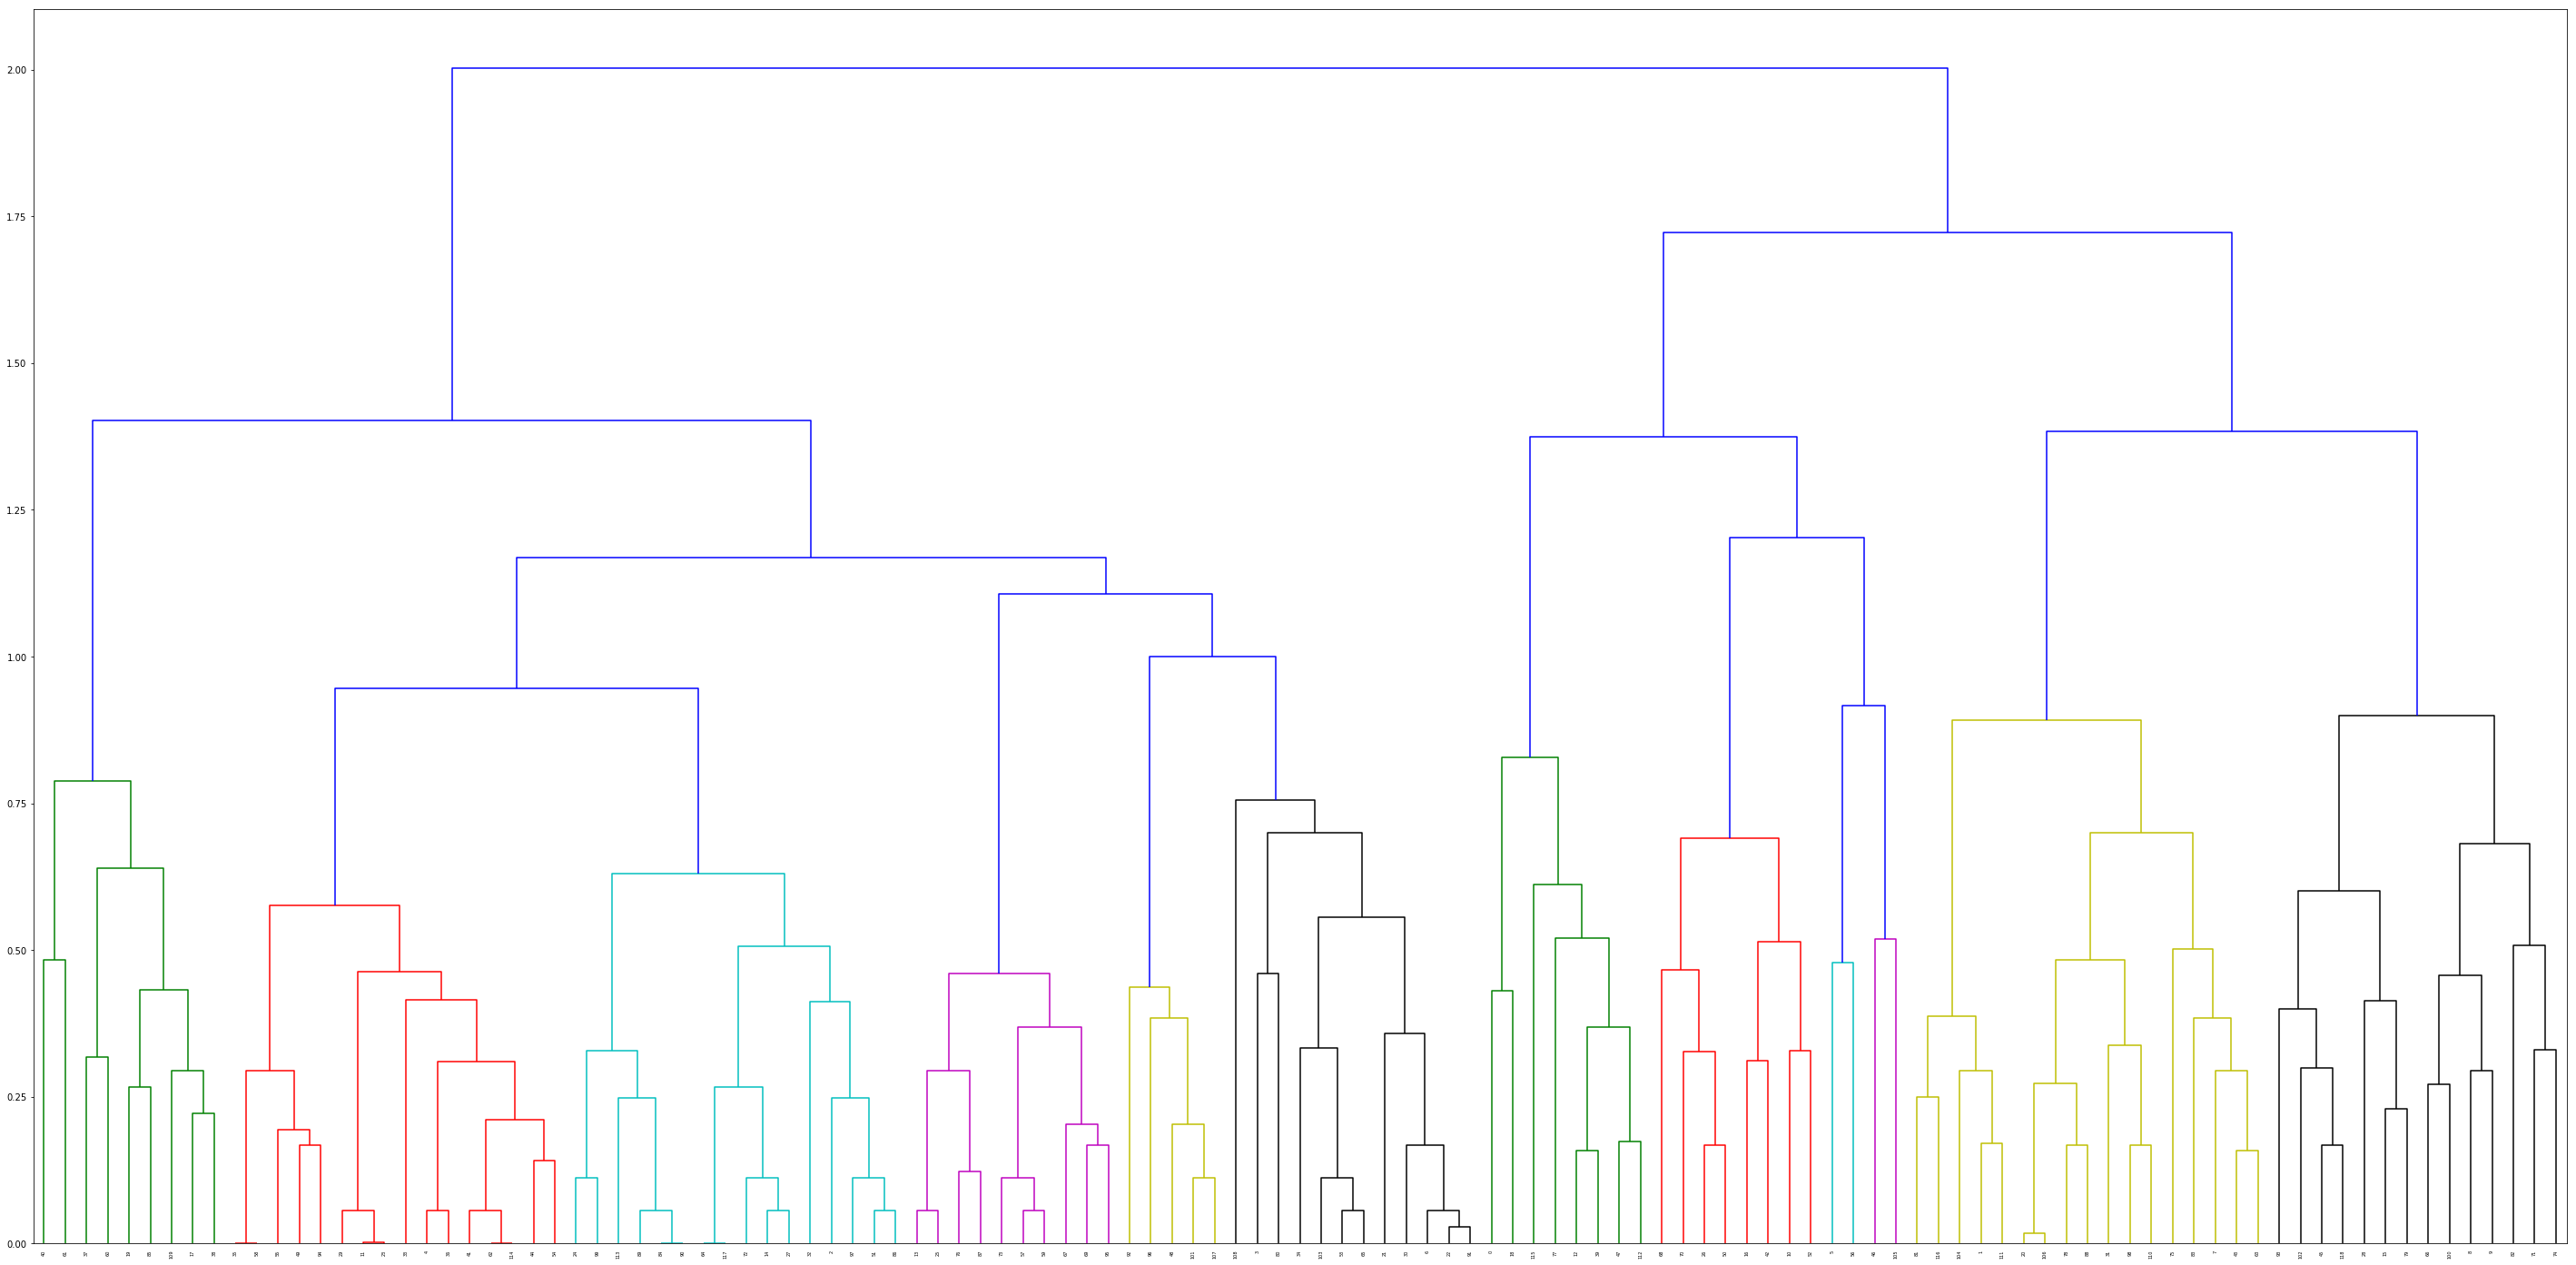

In [171]:
clusters = linkage(features, method = 'complete')
plt.figure(figsize=(50,25))
dendrogram(clusters, leaf_rotation = 90, color_threshold = 0.9)
plt.show()

As it can be seen, all data can be split into two clusters.

However, to make a recommendation engine, we need to be more specific. So, we can either with 4-5 or around 8-12 clusters.

For our case, however, to make engine more specific, let's take **12 clusters**.

<a id='tsne'></a>
# t-SNE

Such decision can also be confirmed by seeing t-SNE transformed scatter plot:

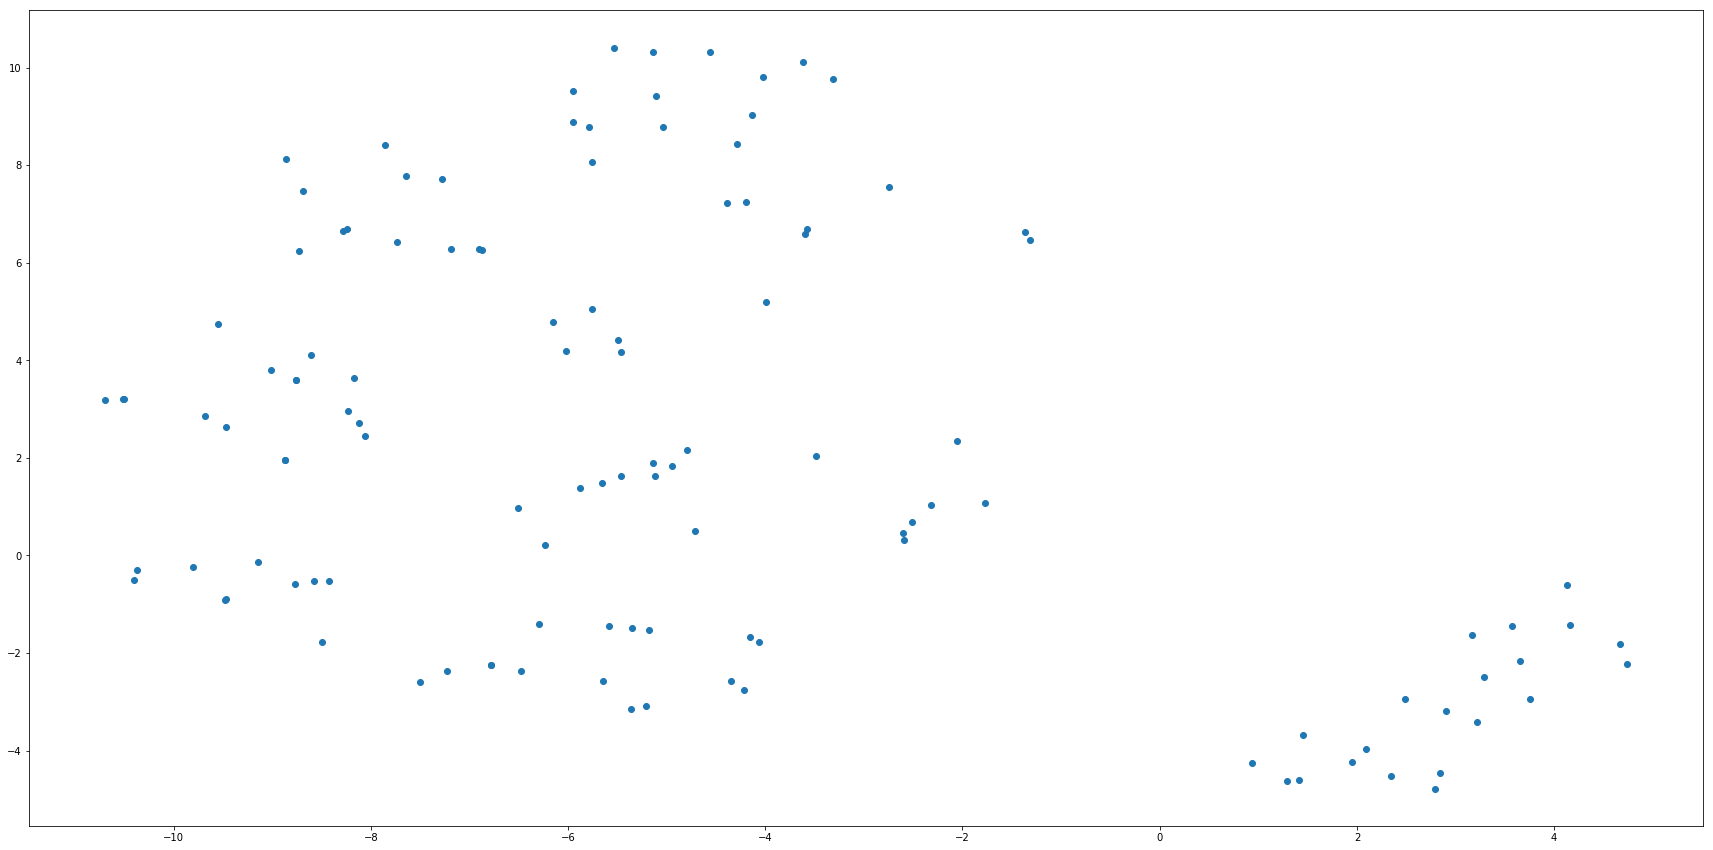

In [170]:
tsne = TSNE()
transformedFeatures = tsne.fit_transform(features) 
plt.figure(figsize=(30,15))
plt.scatter(transformedFeatures[:,0], transformedFeatures[:,1])
plt.show()

12 clusters can be visually separated from this chart.

<a id='kmeans'></a>
# Step-by-step K-means

<a id='rec'></a>
## Recursive K-Means

Let's implement recursive function, that takes dataframe and number of clusters as parametes and returns labels for created clusters. Optional argument `labels` can be specified to set initial state of the algorythm.

In [8]:
def recursiveKMeans(d, k, *labels):
    if labels == ():
        labels = (pd.Series(np.random.randint(0, k, len(d))),)

    labels = labels[0]
    
    def labelClusterInKMeans(point, centroids):
        distances = np.array([np.linalg.norm(centroid - point) for centroid in centroids])
        return np.argmin(distances)

    def updateCentroids(labels):
        return [d.iloc[labels[labels == i].index.tolist()].mean() for i in labels.unique()]         
        
    newLabels = pd.Series([labelClusterInKMeans(row, updateCentroids(labels)) for _, row in d.iterrows()])
    
    #     base
    if labels.equals(newLabels):
        return labels
    
    return recursiveKMeans(d, k, newLabels)

In [9]:
recursiveKMeans(features, 12)

0      0
1      1
2      0
3      1
4      0
5      2
6      1
7      1
8      2
9      2
10     2
11     0
12     2
13     3
14     0
15     2
16     2
17     3
18     2
19     3
20     1
21     1
22     1
23     0
24     3
25     3
26     3
27     0
28     2
29     0
      ..
89     3
90     3
91     1
92     3
93     2
94     0
95     0
96     3
97     0
98     2
99     3
100    2
101    3
102    2
103    1
104    1
105    2
106    1
107    3
108    1
109    3
110    2
111    1
112    2
113    3
114    0
115    2
116    1
117    0
118    2
Length: 119, dtype: int64

<a id='iter'></a>
## Iterative K-Means
A functions kmeans() that accepts a dataframe and k as parameters, and returns the clusters created.

In [10]:
def kmeans(d, k):
    
    def labelClusterInKMeans(point):
        distances = np.array([np.linalg.norm(centroid - point) for centroid in centroids])
        return np.argmin(distances)

    def updateCentroids():
        return [d.iloc[labels[labels == i].index.tolist()].mean() for i in labels.unique()] 
    
    #     random centroids
    centroids = ['x'] #'x' is needed just for first initial comparison in a loop below
    
    centroidsNew = []
    for i in range(k):
        centroidsNew.append(np.random.uniform(features.min(), features.max()))
    
    while not all([np.array_equal(c1, c2) for c1, c2 in zip(centroidsNew, centroids)]):
        centroids = centroidsNew
    #     label clusters
        labels = pd.Series([labelClusterInKMeans(row) for _, row in d.iterrows()])
    
    #     update centroids
        centroidsNew = updateCentroids()
    
    return labels

In [11]:
kmeans(features, 12)

0      0
1      1
2      2
3      0
4      1
5      3
6      1
7      1
8      0
9      0
10     3
11     1
12     0
13     2
14     1
15     0
16     3
17     3
18     0
19     3
20     1
21     2
22     1
23     1
24     2
25     2
26     3
27     1
28     0
29     1
      ..
89     2
90     2
91     1
92     2
93     0
94     2
95     2
96     2
97     2
98     0
99     2
100    0
101    2
102    0
103    1
104    1
105    0
106    1
107    2
108    2
109    3
110    0
111    1
112    0
113    2
114    1
115    0
116    1
117    1
118    0
Length: 119, dtype: int64

<a id='class'></a>
## K-Means Class

Let's now implement a class that will have similar behaviour as `sklearn.cluster.KMeans`.  
It will be initialized by number of clusters.  
`predict` function is used to predict cluster of point based on created cluster centers.  
`fit` will initialize and fit cluster centers and label data.  
[More about initialization methods.](https://en.wikipedia.org/wiki/K-means_clustering#Initialization_methods)

In [12]:
class myKMeans:
    
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
    
    def predict(self, point):
        distances = np.array([np.linalg.norm(centroid - point) for centroid in self.cluster_centers_])
        return np.argmin(distances)
    
    def fit(self, d, initializationMethod = 'Forgy'):
        
        def updateCentroids():
            return [d.iloc[self.labels_[self.labels_ == i].index.tolist()].mean() for i in self.labels_.unique()] 

        self.cluster_centers_ = ['x'] #'x' is needed just for first initial comparison in a loop below

        if initializationMethod == 'Random Points':
            new_cluster_centers = []
            for i in range(self.n_clusters):
                new_cluster_centers.append(np.random.uniform(d.min(), d.max()))
                
        elif initializationMethod == 'Forgy':
            new_cluster_centers = d.sample(self.n_clusters).as_matrix()
            
        elif initializationMethod == 'Random Partition':
            self.labels_ = pd.Series(np.random.randint(0, self.n_clusters, len(d)))
            new_cluster_centers = updateCentroids()

        while not all([np.array_equal(c1, c2) for c1, c2 in zip(new_cluster_centers, self.cluster_centers_)]):
            self.cluster_centers_ = new_cluster_centers
    #     label clusters
            self.labels_ = pd.Series([self.predict(row) for _, row in d.iterrows()])
    #     update centroids
            new_cluster_centers = updateCentroids()

Let's try using this object:

In [13]:
myKMeansObject  = myKMeans(12)
myKMeansObject.fit(features)

In [14]:
print(myKMeansObject.labels_[:5])
print(myKMeansObject.cluster_centers_)
print(myKMeansObject.predict([3.59, 284.81, 634.6, 781.95, 583.72]))

0    0
1    1
2    2
3    1
4    2
dtype: int64
[GPA                  0.602525
calories_chicken     0.230769
calories_scone       0.124402
tortilla_calories    0.292152
turkey_calories      0.111611
dtype: float64, GPA                  0.735556
calories_chicken     0.788317
calories_scone       0.108033
tortilla_calories    0.201979
turkey_calories      0.344971
dtype: float64, GPA                  0.717328
calories_chicken     0.795945
calories_scone       0.141561
tortilla_calories    0.827586
turkey_calories      0.547286
dtype: float64, GPA                  0.573944
calories_chicken     0.747253
calories_scone       1.000000
tortilla_calories    0.827778
turkey_calories      0.431683
dtype: float64]
3


<a id='sklearn'></a>
# sklearn.cluster

Next code simply takes `sklearn.cluster.KMeans` class and uses it.

In [144]:
model = KMeans(n_clusters=12)
model.fit(features)
clusters = pd.Series(model.labels_)

Let's see means of each variable for each cluster:

In [145]:
for group in clusters.unique():
    print(pd.DataFrame(scaler.inverse_transform(
        features.iloc[[x for x in clusters[clusters == group].index.tolist()]]),
                 columns=features.columns).mean(axis=0))
    print('=================')

GPA                     2.3
calories_chicken      430.0
calories_scone        367.5
tortilla_calories    1052.5
turkey_calories       345.0
dtype: float64
GPA                    3.677571
calories_chicken     612.857143
calories_scone       405.000000
tortilla_calories    827.142857
turkey_calories      701.428571
dtype: float64
GPA                     3.458038
calories_chicken      660.769231
calories_scone        407.884615
tortilla_calories    1026.538462
turkey_calories       494.038462
dtype: float64
GPA                    3.050000
calories_chicken     483.571429
calories_scone       980.000000
tortilla_calories    878.571429
turkey_calories      367.142857
dtype: float64
GPA                    3.439167
calories_chicken     628.333333
calories_scone       385.000000
tortilla_calories    688.750000
turkey_calories      448.333333
dtype: float64
GPA                    3.505
calories_chicken     413.500
calories_scone       367.500
tortilla_calories    832.500
turkey_calories      422

Basic idea of what represents each cluster can be got from here.  
For example, first cluster has low GPA, thinks that turkey is very low calory food and tortilla is high calory food.

<a id='comparison'> </a>
## Basic Comparison

Let's do some very basic comparison of what our methods give.  
To do this we'll check sizes of each cluster for each method.  
Note - for custom methods initial state can change clusters a bit, so, result can be changed on notebook rerun.

In [150]:
print('sklearn')
print(clusters.value_counts())
print('')

print('Iterative')
print(kmeans(features, 12).value_counts())
print('')

print('Recursive')
print(recursiveKMeans(features, 12).value_counts())
print('')

print('Class (iterative)')
print(myKMeansObject.labels_.value_counts())

sklearn
11    26
6     14
0     12
7     10
4     10
3      9
1      8
10     7
9      7
5      7
2      7
8      2
dtype: int64

Iterative
5     26
2     26
9     12
7     11
8     10
4      9
10     7
3      6
6      5
1      5
0      2
dtype: int64

Recursive
6     14
2     14
3     13
1     13
9     12
8     10
5     10
4      9
11     7
0      7
10     5
7      5
dtype: int64

Class (iterative)
2    58
0    22
3    20
1    19
dtype: int64


<a id='prediction'></a>
# Prediction

Let's create a function (`printCoupon`) that accepts parameters, which represent the characteristics of the student, and will print coupons according to the cluster the student belongs to.  

In [147]:
def predict(features):
    return model.predict(scaler.transform(np.array(features).reshape(1, -1)))[0]

def printCoupon(GPA, calories_chicken, calories_scone, tortilla_calories, turkey_calories):    
    
    coupons = [
            "Psss, our chicken with fresh vegetables is awaiting you! Check restaurant nearby or order a delivery!",
            "You need more energy to keep good grades going! Try  our delicious scones! Tasty, but not too much calories",
            "To score even better in your studies, try our new scone or our tasty chicken that can fulfil your brain with energy!",
            "You know what is both tasty and low on calories? Right! That's our new turkey!",
            "Go get your food today at new all-you-can-eat buffet at the University of the Pacific!",
            "Wanna get a lot of food? Visit us!",
            "Waiting for you to serve you best dishes.",
            "How about nice and tasty cone for today's lunch?",
            "Tasty and low on calories!",
            "What can be better than our scone? Only our chicken!",
            "Turkey - low on calories, but high on deliciosness!",
            "Thinking what do you preffer, chicken or scone? Take both!"
            ]
    
    print(coupons[predict([GPA, calories_chicken, calories_scone, tortilla_calories, turkey_calories])])

Let's run our coupon function for 10 random data points.

In [181]:
for i in range(10):
    x = np.round(np.random.uniform(scaler.data_min_, scaler.data_max_), 2)
    print('GPA,\t calories_chicken,\t calories_scone,\t tortilla_calories,\t turkey_calories')
    print(*x, sep='\t\t  ')
    printCoupon(x[0], x[1], x[2], x[3], x[4])
    print('==================================================================================================\n')

GPA,	 calories_chicken,	 calories_scone,	 tortilla_calories,	 turkey_calories
3.32		  325.57		  883.37		  922.62		  662.6
Wanna get a lot of food? Visit us!

GPA,	 calories_chicken,	 calories_scone,	 tortilla_calories,	 turkey_calories
2.75		  630.89		  598.83		  644.6		  580.01
Psss, our chicken with fresh vegetables is awaiting you! Check restaurant nearby or order a delivery!

GPA,	 calories_chicken,	 calories_scone,	 tortilla_calories,	 turkey_calories
2.82		  698.16		  956.45		  717.55		  509.46
Wanna get a lot of food? Visit us!

GPA,	 calories_chicken,	 calories_scone,	 tortilla_calories,	 turkey_calories
3.88		  459.48		  817.34		  631.34		  734.99
Waiting for you to serve you best dishes.

GPA,	 calories_chicken,	 calories_scone,	 tortilla_calories,	 turkey_calories
3.18		  704.2		  718.91		  950.34		  706.72
You need more energy to keep good grades going! Try  our delicious scones! Tasty, but not too much calories

GPA,	 calories_chicken,	 calories_scone,	 tortilla_calories,	

<a id='mesh'></a>
# 2D prediction mesh

Let's plot 2D prediction mesh.

In [178]:
def plotPredictionMesh(data, cluster_centers, nh=100, meshColor='Pastel2'):
    #     plots colored mesh grid for each point after applying tSNE 
    #     based on cluster centers (from K-Means) and euclidian distance
    
    #     define to which cluster point belongs based on euclidian distance to cluster_centers
    def predict(point, cluster_centers):
        distances = np.array([np.linalg.norm(centroid - point) for centroid in cluster_centers])
        return np.argmin(distances)
    
    #     transform all data together with cluster centers with tSNE
    tsne = TSNE()
    transformed = tsne.fit_transform(data.append(pd.DataFrame(model.cluster_centers_, columns=data.columns)))
    #     separate cluster from other data (copy, to be precise)
    clusterCenters = transformed[-len(cluster_centers):,:]
    
    #     get max and min values of both axis for mesh grid
    x_min, x_max = transformed[:,0].min() - 1, transformed[:,0].max() + 1
    y_min, y_max = transformed[:,1].min() - 1, transformed[:,1].max() + 1
    
    #     mesh step
    h = min((x_max - x_min) / nh, (y_max - y_min) / nh)
    
    #     create mesh grip (grid of points) to color rectangular that are defined by points
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    #     find to which cluster each point belongs
    clusteringForEachMeshPoint = np.array([predict([x,y], clusterCenters) for x,y in np.c_[xx.ravel(), yy.ravel()]])
    
    #     reshape it to fit plt.pcolor
    clusteringForEachMeshPoint = clusteringForEachMeshPoint.reshape(xx.shape)

    #     plot colors       
    plt.figure(figsize=(20,10))
    plt.pcolor(xx, yy, clusteringForEachMeshPoint, cmap=meshColor)
    
    #     and also points with cluster centers
    plt.scatter(transformed[:,0], transformed[:,1])
    plt.scatter(clusterCenters[:,0], clusterCenters[:,1], c='red')

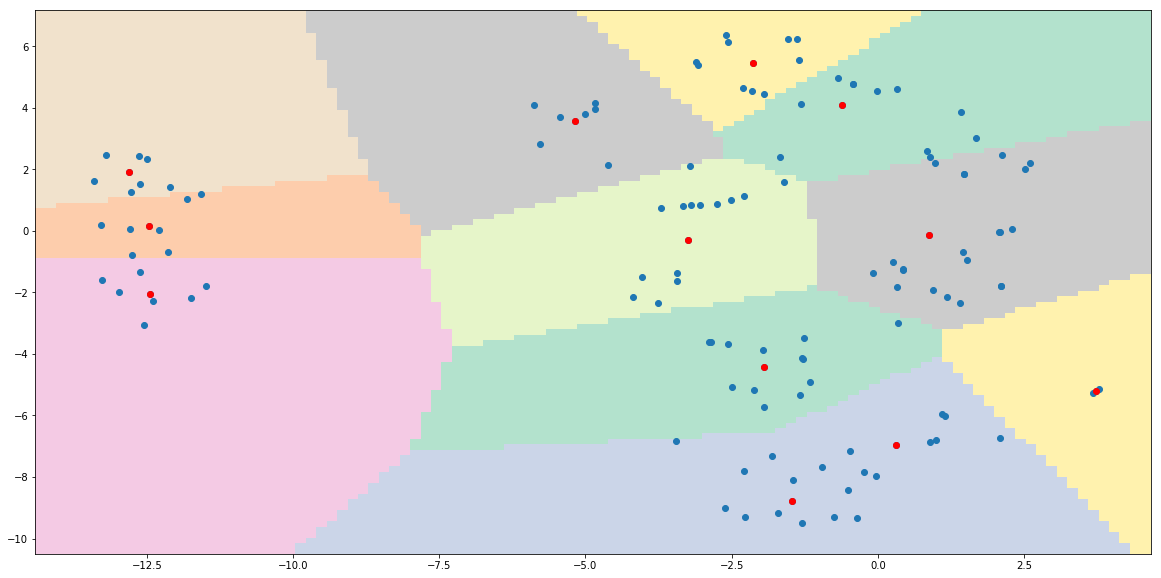

In [180]:
plotPredictionMesh(features, model.cluster_centers_)

It can be used to visualize clusters on plane and to represent algorythm concept and results.

<a id='recommendations'></a>
# Recommendations
During conducted research data exploration was conducted. Based on data exploration five columns were selected as features for unsupervised K-Means clustering, namely `GPA`, `calories_chicken`, `calories_scone`, `tortilla_calories`, `turkey_calories`. After this features data was cleaned. Data was analyzed to find optimal number of clusters. 12 clusters were chosen for this research.  
  
K-Means clustering was implemented in several types. Three custom types were implemented (recursive, iterative, Class-based) and one pre-built from `sklearn.clusters`. Found clusters were analyzed to see which characteristics they represent. 
  
Based on created recommendation engine students can be targeted with different coupons, that are based on their GPA and guessed calories level. This enginge can be extended to work with more variables and to work even if some variable is missing.  
  
Coupon text also should be adjusted to include pictures and be more based on psychometric features of the target audience.  
Depending on goal, number of clusters (groups) can be adjusted to be more specific or more general.  
Results can be visualized for presenting with created prediction mesh function.
